# Assignment 2: Transfer Learning

**Overview**

In this assignment, you will explore **transfer learning** for acoustic activity recognition using a pre-trained deep learning model called **Ubicoustics**. You will evaluate the pre-trained model on your own dataset from Assignment 1, perform various fine-tuning experiments with different strategies and hyperparameters, compare the performance to your previous machine learning models, and (optionally) consider how you might use the model in a real-time acoustic recognition application. This assignment builds on the data and insights from Assignment 1, extending your skills into deep learning approaches.

**Note:** This notebook provides step-by-step sections with placeholders for code and analysis. Follow the instructions in each part, fill in the code where prompted, and answer any questions in the provided Markdown cells. By the end, you should have a complete evaluation of transfer learning for your acoustic recognition task.


**Learning Objectives**
1.   Apply transfer learning concepts to an acoustic activity recognition problem.
2.   Evaluate a pre-trained sound recognition model on a custom dataset.
3.   Fine-tune the pre-trained model under different conditions (e.g., different training data and hyperparameters).
4.   Implement and assess a real-time acoustic recognition approach (conceptually or via discussion).
5.   Compare the performance of deep learning vs. traditional machine learning models.

## Setup and Configuration

This section imports necessary libraries and sets up the environment for working with the Ubicoustics model. We'll use VGGish as a feature extractor and load the pre-trained Ubicoustics model to recognize everyday sounds.

In [2]:
!pip install wget

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import librosa
import librosa.display
import IPython.display as ipd
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
from tensorflow.keras.optimizers import Adam
import time
import hashlib
import random
from tqdm.notebook import tqdm
from pathlib import Path
import warnings
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import wget

# Suppress warnings
warnings.filterwarnings('ignore')

# Mount Google Drive
try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
except:
    print("Error mounting Google Drive. Please run this cell again.")

2025-05-10 18:00:46.563257: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-10 18:00:46.663404: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746918046.699884  440204 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746918046.711353  440204 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746918046.795915  440204 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Error mounting Google Drive. Please run this cell again.


# Ubicoustics Model Loading and Dataset Preparation

In this section, we'll download and load the pre-trained Ubicoustics model. We'll also prepare our dataset from Assignment 1 for evaluation and fine-tuning.

## Ubicoustics Model

The Ubicoustics model is built on top of Google's VGGish audio embedding model. It takes audio spectrograms as input and outputs class probabilities for 30 different everyday sounds.

## VGGish Feature Extraction

VGGish processes audio in the following way:
1. Resamples audio to 16 kHz mono
2. Computes short-time Fourier transform (STFT)
3. Converts to Mel-spectrograms
4. Generates 0.96-second, 96x64 log Mel spectrogram patches

This gives us input with shape (batch_size, 96, 64, 1) for the Ubicoustics model.

In [4]:
# Install official resampy library
!pip install resampy

# Create vggish directory if not exists
!mkdir -p vggish

# Download VGGish dependencies (if not already present)
!wget -O vggish/vggish_input.py https://raw.githubusercontent.com/tensorflow/models/master/research/audioset/vggish/vggish_input.py
!wget -O vggish/vggish_params.py https://raw.githubusercontent.com/tensorflow/models/master/research/audioset/vggish/vggish_params.py
!wget -O vggish/mel_features.py https://raw.githubusercontent.com/tensorflow/models/master/research/audioset/vggish/mel_features.py
!wget -O vggish/resampy.py https://raw.githubusercontent.com/bmcfee/resampy/master/resampy/core.py

# # Import VGGish modules
sys.path.append('./vggish')

import resampy  # Import resampy if needed
from vggish_input import waveform_to_examples, wavfile_to_examples
import vggish_params

# Example usage (optional test)
# waveform_examples = vggish_input.waveform_to_examples(<your_audio_data>, vggish_params.SAMPLE_RATE)

# Configuration (same as your original code)
ACTIVITIES = ['laugh', 'cough', 'clap', 'knock', 'alarm']
ENVIRONMENTS = ['small', 'large']
NUM_INSTANCES = 10
SAMPLE_RATE = 16000  # VGGish uses 16kHz

UBICOUSTICS_LABELS = {
    'dog-bark':0, 'drill':1, 'hazard-alarm':2, 'phone-ring':3, 'speech':4,
    'vacuum':5, 'baby-cry':6, 'chopping':7, 'cough':8, 'door':9,
    'water-running':10, 'knock':11, 'microwave':12, 'shaver':13, 'toothbrush':14,
    'blender':15, 'dishwasher':16, 'doorbell':17, 'flush':18, 'hair-dryer':19,
    'laugh':20, 'snore':21, 'typing':22, 'hammer':23, 'car-horn':24,
    'engine':25, 'saw':26, 'cat-meow':27, 'alarm-clock':28, 'cooking':29
}

UBICOUSTICS_MAPPING = {
    'laugh': 'laugh', 'cough': 'cough', 'clap': 'knock', 'knock': 'knock', 'alarm': 'hazard-alarm'
}

TO_HUMAN_LABELS = {
    'dog-bark': "Dog Barking", 'drill': "Drill In-Use", 'hazard-alarm': "Hazard Alarm",
    'phone-ring': "Phone Ringing", 'speech': "Person Talking", 'vacuum': "Vacuum In-Use",
    'baby-cry': "Baby Crying", 'chopping': "Chopping", 'cough': "Coughing",
    'door': "Door In-Use", 'water-running': "Water Running", 'knock': "Knocking",
    'microwave': "Microwave In-Use", 'shaver': "Shaver In-Use", 'toothbrush': "Toothbrushing",
    'blender': "Blender In-Use", 'dishwasher': "Dishwasher In-Use", 'doorbell': "Doorbell In-Use",
    'flush': "Toilet Flushing", 'hair-dryer': "Hair Dryer In-Use", 'laugh': "Laughing",
    'snore': "Snoring", 'typing': "Typing", 'hammer': "Hammering", 'car-horn': "Car Honking",
    'engine': "Vehicle Running", 'saw': "Saw In-Use", 'cat-meow': "Cat Meowing",
    'alarm-clock': "Alarm Clock", 'cooking': "Utensils and Cutlery"
}

def generate_dataset_id(name):
    """
    Generate a 5-digit random number based on the hash of the name.
    Use this as your dataset folder name.
    """
    hash_object = hashlib.md5(name.encode())
    hex_dig = hash_object.hexdigest()
    seed = int(hex_dig, 16) % (10**8)
    random.seed(seed)
    return random.randint(10000, 99999)

# Enter your name to generate your dataset ID
student_name = "Sharwin Patil"
dataset_id = generate_dataset_id(student_name)


# BASE_PATH = "/content/drive/MyDrive/CSXXX"
BASE_PATH = "."
MODEL_PATH = f"{BASE_PATH}/models"
CLASS_DATASET_PATH = f"{BASE_PATH}/class_dataset"

os.makedirs(MODEL_PATH, exist_ok=True)

DATASET_PATH = f"{BASE_PATH}/{dataset_id}"
print(f"Using dataset path: {DATASET_PATH}")

--2025-05-10 18:00:49--  https://raw.githubusercontent.com/tensorflow/models/master/research/audioset/vggish/vggish_input.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3536 (3.5K) [text/plain]
Saving to: ‘vggish/vggish_input.py’

vggish/vggish_input 100%[===================>]   3.45K  --.-KB/s    in 0s      

2025-05-10 18:00:49 (45.4 MB/s) - ‘vggish/vggish_input.py’ saved [3536/3536]

--2025-05-10 18:00:49--  https://raw.githubusercontent.com/tensorflow/models/master/research/audioset/vggish/vggish_params.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awai

# A2.1: Evaluating Pre-trained Ubicoustics (5 points)

In this section, you will use the pre-trained Ubicoustics model to classify the audio dataset you collected in Assignment 1. This will serve as a baseline to see how a state-of-the-art acoustic model performs on your specific 5-class problem without any fine-tuning. You will also analyze the results across your two recording environments.

## Instructions:

1.   Make sure your Assignment 1 audio dataset (5 activities × 10 instances × 2 environments = 100 recordings) is available in this notebook. You may need to mount your Google Drive or upload your data so the notebook can access your audio files.
2.   Load the pre-trained Ubicoustics model. (The model file and any necessary helper code are provided in this notebook or via instructions. If a separate download or library is required, follow those instructions here.)
3.   A mapping from the Ubicoustics model's output classes to your 5 activity classes is provided. Use this mapping to convert the model's predictions to your label set. (For example, Ubicoustics might predict many sound classes; you'll map those predictions to the closest of your five classes: cough, laugh, clap, knock, alarm.)
4.   Run the model on each of your audio recordings and obtain the predicted label for each file.
5.   Calculate and report the overall accuracy of the model on your dataset (i.e., the fraction of recordings correctly classified by Ubicoustics).
6.   Compute a confusion matrix for the predictions vs. true labels to see how the model confuses the different activities. This will show which specific activities were correctly or incorrectly recognized.
7.   Compare performance across your two environments: calculate the accuracy on recordings from the small room vs. the large room separately. Determine whether the environment affected the model's performance.

In [5]:
# Mount Google Drive (directory of your audio data)
# from google.colab import drive
# drive.mount('/content/drive')


# TODO: Load the pre-trained Ubicoustics model
# For example, if a model file is provided, you might use:
!wget -O example_model.hdf5 https://www.dropbox.com/s/cq1d7uqg0l28211/example_model.hdf5?dl=1

model = load_model('example_model.hdf5', compile=False)
model.compile(optimizer=Adam(learning_rate=9.999999747378752e-05), loss='categorical_crossentropy')
model.summary()

--2025-05-10 18:00:50--  https://www.dropbox.com/s/cq1d7uqg0l28211/example_model.hdf5?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/yibnx0k8qpoz3qqes2td6/example_model.hdf5?rlkey=hyvw9icy148yaa4ni493g4nyu&dl=1 [following]
--2025-05-10 18:00:50--  https://www.dropbox.com/scl/fi/yibnx0k8qpoz3qqes2td6/example_model.hdf5?rlkey=hyvw9icy148yaa4ni493g4nyu&dl=1
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc27e0658d1cebe66e9738a4395b.dl.dropboxusercontent.com/cd/0/inline/CpebTiVuFIYdJC95YtiFgM-N0aY0pz8HYQDQ6-l-eC7jI5o4BBkRsACjuYxsHAkyP1GuvUJXWvuEaxnNC9Obob6omTt9uJ__Qzo9ZRoHvUjCYd7UYi4EXrDfOLGp7e38x7M/file?dl=1# [following]
--2025-05-10 18:00:50--  https://uc27e0658d1cebe66e9738a4395b.dl.dropboxusercontent.

W0000 00:00:1746918080.754340  440204 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_1 (InputLayer)            │ (None, 96, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 96, 64, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 48, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 48, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 24, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_1 (Conv2D)                │ (None, 24, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_2 (Conv2D)                │ (None, 24, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 12, 8, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4_1 (Conv2D)                │ (None, 12, 8, 512)     │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4_2 (Conv2D)                │ (None, 12, 8, 512)     │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool4 (MaxPooling2D)            │ (None, 6, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1_1 (Dense)                   │ (None, 4096)           │    50,335,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1_2 (Dense)                   │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ main_out (Dense)                │ (None, 30)             │         3,870 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,145,054 (275.21 MB)

 Trainable params: 72,145,054 (275.21 MB)

 Non-trainable params: 0 (0.00 B)

Found 100 audio files.
First 10 True Labels: ['knock', 'alarm', 'alarm', 'laugh', 'knock', 'alarm', 'laugh', 'clap', 'clap', 'laugh']
First 10 Environments: ['small', 'small', 'small', 'large', 'large', 'large', 'small', 'large', 'small', 'large']


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

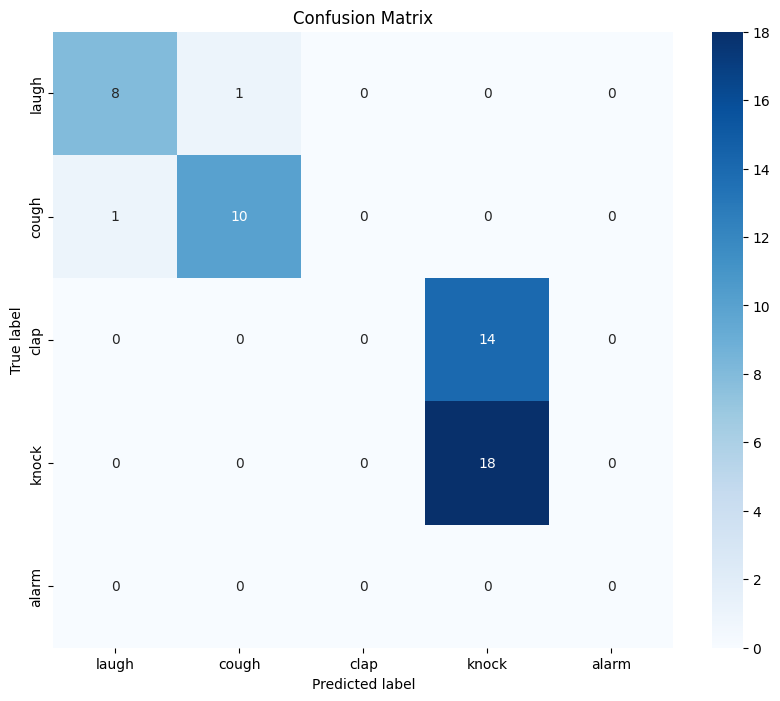

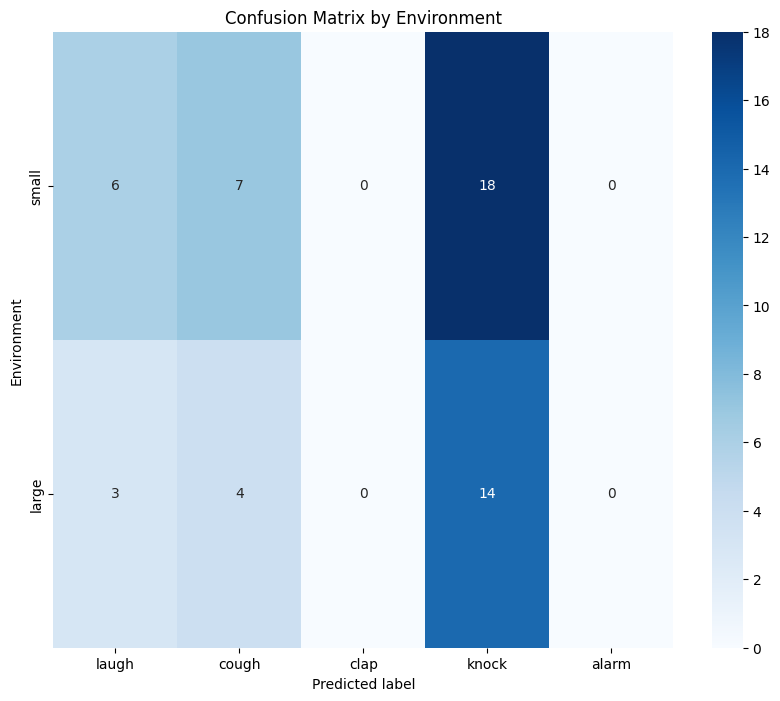

In [6]:
# TODO: Mapping from Ubicoustics classes to your classes
def map_ubicoustics_to_classes(ubicoustics_class):
    # return UBICOUSTICS_MAPPING.get(ubicoustics_class, 'unknown')
    return UBICOUSTICS_LABELS.get(ubicoustics_class, 'unknown')

# TODO: Prepare your data: list all audio file paths and their true labels
audio_files = []    # List of file paths for your 100 audio recordings
true_labels = []    # List of true labels (e.g., 'cough', 'laugh', etc.) for each recording
environments = []   # List of environment labels ('small' or 'large') for each recording (parallel to the files)
file_list = os.listdir(DATASET_PATH)
for file in file_list:
  #ignore directories
  if os.path.isdir(file):
    continue
  # ignore non-audio files
  if not file.endswith('.wav'):
    continue
  # Extract the environment and activity from the filename
  # Example filename: "cough_small_1.wav" -> ['path', 'cough', 'small']
  parts = file.split('_')
  if len(parts) != 3:
    print(f"Skipping file {file} due to unexpected format.")
    continue
  label = parts[0]
  environment = parts[1]
  path = os.path.join(DATASET_PATH, file)
  audio_files.append(path)
  true_labels.append(label)
  environments.append(environment)
assert len(audio_files) == len(true_labels), "Mismatch in number of audio files and true labels"
assert len(audio_files) == len(environments), "Mismatch in number of audio files and environments"
print(f"Found {len(audio_files)} audio files.")
print(f"First 10 True Labels: {true_labels[:10]}")  
print(f"First 10 Environments: {environments[:10]}")

# TODO: Run the model on each audio file and collect predictions
pred_labels = []
for audio_file in tqdm(audio_files):
  # Load the audio file
  audio, sr = librosa.load(audio_file, sr=SAMPLE_RATE)
  # Convert to VGGish input format
  examples = waveform_to_examples(audio, sr)
  # Make predictions
  predictions = model.predict(examples)
  # Get the predicted class
  predicted_class = np.argmax(predictions, axis=1)[0]
  # Reverse the label to get the original Ubicoustics class
  predicted_class = list(UBICOUSTICS_LABELS.keys())[list(UBICOUSTICS_LABELS.values()).index(predicted_class)]
  # Map to your class if needed
  if predicted_class in UBICOUSTICS_MAPPING:
    predicted_class = UBICOUSTICS_MAPPING[predicted_class]
  pred_labels.append(predicted_class)
assert len(pred_labels) == len(audio_files), "Mismatch in number of predictions and audio files"
print(f"First 10 Predicted Labels: {pred_labels[:10]}")
# TODO: Calculate and report the overall accuracy
accuracy = accuracy_score(true_labels, pred_labels)
print(f"Overall accuracy: {accuracy * 100:.2f}%")


# TODO: Compute a confusion matrix for the predictions vs. true labels
conf_matrix = confusion_matrix(true_labels, pred_labels, labels=ACTIVITIES)
conf_matrix_df = pd.DataFrame(conf_matrix, index=ACTIVITIES, columns=ACTIVITIES)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# TODO: Compare performance across your two environments:
env_conf_matrix = pd.DataFrame(index=ENVIRONMENTS, columns=ACTIVITIES, dtype=int)
for env in ENVIRONMENTS:
    env_labels = [true_labels[i] for i in range(len(true_labels)) if environments[i] == env]
    env_pred_labels = [pred_labels[i] for i in range(len(pred_labels)) if environments[i] == env]
    env_conf_matrix.loc[env] = confusion_matrix(env_labels, env_pred_labels, labels=ACTIVITIES).sum(axis=0)
env_conf_matrix = env_conf_matrix.fillna(0).astype(int)  # Ensure all values are numeric
plt.figure(figsize=(10, 8))
sns.heatmap(env_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix by Environment')
plt.ylabel('Environment')
plt.xlabel('Predicted label')
plt.show()

In [7]:
# import numpy as np
# out = model.predict(np.random.rand(1, 96, 64, 1).astype(np.float32))

# predicted_class_idx = np.argmax(out)
# idx_to_label = {v: k for k, v in UBICOUSTICS_LABELS.items()}
# predicted_label = idx_to_label[predicted_class_idx]

# print(f"Predicted label: {predicted_label}")

**Discussion:** Describe the performance of the pre-trained model on your dataset in your report.


*   What is the overall accuracy, and is it satisfactory for your needs?
*   Examine the confusion matrix: which activities are most frequently mistaken for one another? Are there specific classes the model struggles with?
*   Compare the accuracy between the two environments. Did the model perform better in the small room or the large room? Why do you think that might be? Consider aspects like background noise or acoustics in each environment.
*   This analysis will serve as a baseline when you later fine-tune the model.

# A2.2: Fine-tuning with Environment-based Cross-validation (5 points)

In this section, we'll fine-tune the Ubicoustics model using environment-based cross-validation. We'll train on data from one environment, test on the other, and reverse the process.

## Instructions:

1. Split your dataset by environment: Create two subsets of your data: one for all recordings in the small room and one for all recordings in the large room. These will serve as two different training/testing sets. For example, when training on the small-room data, the large-room data will be the test set, and vice versa.
2. Fine-tune on one environment: Start by fine-tuning the model using the small-room data as the training set and the large-room data as the test set. Use the Ubicoustics model.
3. Experiment with hyperparameters: Try at least 3 different learning rates (for example: 0.01, 0.001, 0.0001) and 3 different epoch counts (for example: 10, 20, 30 epochs) in your fine-tuning experiments. You can do this systematically (e.g., in a loop) or manually adjust and run multiple times. Keep track of the results for each combination of learning rate and epochs.
4. Swap environments and repeat: After experimenting with training on small-room and testing on large-room, perform the reverse: fine-tune the model using the large-room data as the training set and test on the small-room data. You can use the insights from the first set of experiments to choose a few promising hyperparameter combinations, or systematically try a few options again. Record the accuracy results for these runs as well.
5. Identify the best hyperparameters: Based on your experiments, determine which learning rate and number of epochs gave the highest test accuracy in these cross-environment tests. You might find one combination that consistently works well for both directions, or you might choose one that gives the best average performance across the two scenarios. This will be considered the "optimal" hyperparameter setting for fine-tuning in an environment transfer scenario.
6. Compare to the pre-trained model: Take note of how the fine-tuned model(s) performed versus the original pre-trained model (from A2.1) on the same test sets.

Make sure to document which layers you froze and which you trained in your fine-tuning process (this is important for reporting and for understanding how much of the model was updated during fine-tuning).

In [32]:
# TODO: Prepare data for environment-based training
# X_small, y_small: features (or audio data) and labels for small-room recordings
# X_large, y_large: features (or audio data) and labels for large-room recordings

X_small = []  # Your small-room audio data prepared for model input
y_small = []  # Labels for small-room data (one-hot encoded or integers for classes)
X_large = []  # Large-room audio data
y_large = []  # Labels for large-room data

zipped_data = list(zip(audio_files, true_labels, environments))
for audio_file, true_label, environment in tqdm(zipped_data):
    # Load the audio file
    audio, sr = librosa.load(audio_file, sr=SAMPLE_RATE)
    # Convert to VGGish input format
    examples = waveform_to_examples(audio, sr)
    # examples.reshape(len(examples), 96, 64, 1)  # Reshape to match model input
    examples = examples[..., np.newaxis]  # (96, 64, 1) for VGGish
    features = np.mean(examples, axis=0)  # Mean pooling to get a single feature vector
    # Append to the appropriate list based on the environment
    ubi_label = UBICOUSTICS_MAPPING.get(true_label, "unknown")  # Map to Ubicoustics labels
    label = UBICOUSTICS_LABELS.get(ubi_label, -1)  # Get the integer label
    if environment == 'small':
        X_small.append(features)
        y_small.append(label)
    elif environment == 'large':
        X_large.append(features)
        y_large.append(label)
    else:
        print(f"Unknown environment: {environment}. Skipping this file.")

X_small = np.array(X_small)
y_small = np.array(y_small)
X_large = np.array(X_large)
y_large = np.array(y_large)

print(f"Small-room data size: {X_small.shape}, Labels size: {y_small.shape}")
print(f"Large-room data size: {X_large.shape}, Labels size: {y_large.shape}")

  0%|          | 0/100 [00:00<?, ?it/s]

Small-room data size: (50, 96, 64, 1), Labels size: (50,)
Large-room data size: (50, 96, 64, 1), Labels size: (50,)


In [9]:
# TODO: Fine-tune model and experiment with different hyperparameters
def create_fine_tuning_model(base_model, num_layers_to_freeze=0):
    """
    Create a model for fine-tuning based on base model.

    Args:
        base_model: Base Ubicoustics model
        num_layers_to_freeze: Number of layers to freeze from the beginning

    Returns:
        Model for fine-tuning
    """
    # Clone the base model
    model = keras.models.clone_model(base_model)
    model.set_weights(base_model.get_weights())

    # Total number of layers
    total_layers = len(model.layers)

    # Freeze layers if specified
    if num_layers_to_freeze > 0:
        # Special case for last layer only
        if num_layers_to_freeze == -1:
            # Freeze all layers except the last one
            for layer in model.layers[:-1]:
                layer.trainable = False
            model.layers[-1].trainable = True
            print(f"Freezing all layers except the last one")
        else:
            # Freeze specified number of layers from the beginning
            for layer in model.layers[:num_layers_to_freeze]:
                layer.trainable = False
            print(f"Freezing {num_layers_to_freeze} layers out of {total_layers}")
    else:
        print("All layers are trainable")
    # Count trainable parameters
    K = keras.backend
    trainable_count = sum(K.count_params(w) for w in model.trainable_weights)
    non_trainable_count = sum(K.count_params(w) for w in model.non_trainable_weights)

    print(f"Total parameters: {trainable_count + non_trainable_count}")
    print(f"Trainable parameters: {trainable_count}")
    print(f"Non-trainable parameters: {non_trainable_count}")

    # Compile model
    model.compile(
        optimizer='adam',  # Will be replaced during fine-tuning
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def fine_tune_model(model, X_train, y_train, X_test, y_test, learning_rate, num_epochs):
    """
    Fine-tune model on given data.

    Args:
        model: Model to fine-tune
        X_train, y_train: Training data
        X_test, y_test: Testing data
        learning_rate: Learning rate for optimization
        num_epochs: Number of training epochs

    Returns:
        Fine-tuned model and training history
    """
    # Create optimizer with specified learning rate
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    # Compile model
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Create callbacks
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]

    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=num_epochs,
        batch_size=32,
        validation_data=(X_test, y_test),
        callbacks=callbacks,
        verbose=0
    )

    # Evaluate model
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test accuracy: {test_acc}")
    print(f"Test loss: {test_loss}")

    return model, history

Training with learning rate: 0.01, epochs: 10, frozen layers: 0
All layers are trainable
Total parameters: 72145054
Trainable parameters: 72145054
Non-trainable parameters: 0
Test accuracy: 0.20000000298023224
Test loss: 1.3863399028778076
Best model updated with learning rate: 0.01, epochs: 10, frozen layers: 0
Training with learning rate: 0.01, epochs: 10, frozen layers: 1
Freezing 1 layers out of 16
Total parameters: 72145054
Trainable parameters: 72145054
Non-trainable parameters: 0
Test accuracy: 0.20000000298023224
Test loss: 1.6325197219848633
Training with learning rate: 0.01, epochs: 10, frozen layers: 2
Freezing 2 layers out of 16
Total parameters: 72145054
Trainable parameters: 72144414
Non-trainable parameters: 640
Test accuracy: 0.20000000298023224
Test loss: 4.94782829284668
Training with learning rate: 0.01, epochs: 10, frozen layers: -1
All layers are trainable
Total parameters: 72145054
Trainable parameters: 72145054
Non-trainable parameters: 0
Test accuracy: 0.4000000

Test accuracy: 0.9800000190734863
Test loss: 0.1261102706193924
Best model saved to ./models/best_large_train_model.h5


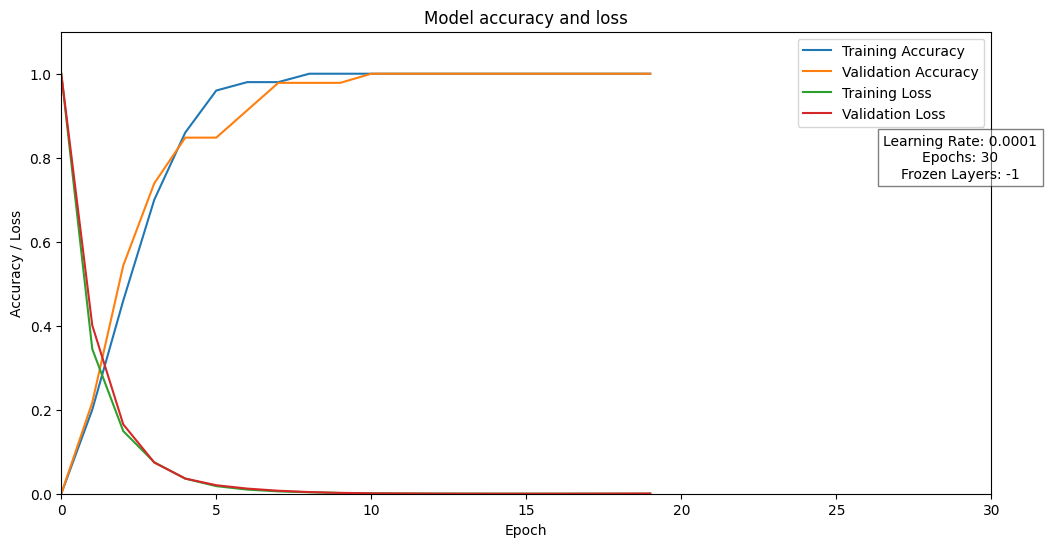

In [ ]:
# TODO: Swap environments and repeat
learning_rates = [1e-2, 1e-3, 1e-4]
epochs = [10, 20, 30]
frozen_layers = [0, 1, 2, -1]  # -1 means freeze all but the last layer

def grid_search_fine_tuning(X_train, y_train, X_test, y_test, lr, num_epochs, frozen_layers):
    # Create fine-tuning model
    fine_tuning_model = create_fine_tuning_model(model, num_layers_to_freeze=frozen_layers)
    # Fine-tune model
    fine_tuned_model, history = fine_tune_model(
        fine_tuning_model,
        X_train,
        y_train,
        X_test,
        y_test,
        learning_rate=lr,
        num_epochs=num_epochs
    )
    return fine_tuned_model, history

def plot_history(history, lr, num_epochs, frozen_layers, plot_name):
    acc, loss, val_acc, val_loss = history.history['accuracy'], history.history[
        'loss'], history.history['val_accuracy'], history.history['val_loss']
    # Normalize acc and loss to [0, 1]
    acc = (acc - np.min(acc)) / (np.max(acc) - np.min(acc))
    loss = (loss - np.min(loss)) / (np.max(loss) - np.min(loss))
    val_acc = (val_acc - np.min(val_acc)) / (np.max(val_acc) - np.min(val_acc))
    val_loss = (val_loss - np.min(val_loss)) / \
        (np.max(val_loss) - np.min(val_loss))
    plt.figure(figsize=(12, 6))
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    # for key in history.history.keys():
    #     plt.plot(history.history[key], label=key)
    plt.title('Model accuracy and loss')
    plt.ylabel('Accuracy / Loss')
    plt.xlabel('Epoch')
    plt.text(num_epochs - 1, 0.8, f"Learning Rate: {lr}\nEpochs: {num_epochs}\nFrozen Layers: {frozen_layers}",
             ha='center', va='center', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
    plt.ylim(0, 1.1)
    plt.xlim(0, num_epochs)
    plt.legend(loc='upper right')
    plt.savefig(f"{plot_name}_{lr}_{num_epochs}_{frozen_layers}.png")

# Grid search with small-room training and large-room testing
def find_best_model(X_train, y_train, X_test, y_test, model_name):
    best_model = None
    best_history = None
    for lr in learning_rates:
        for num_epochs in epochs:
            for frozen_layer in frozen_layers:
                print(f"Training with learning rate: {lr}, epochs: {num_epochs}, frozen layers: {frozen_layer}")
                fine_tuned_model, history = grid_search_fine_tuning(
                    X_train=X_train,
                    y_train=y_train,
                    X_test=X_test,
                    y_test=y_test,
                    lr=lr, 
                    num_epochs=num_epochs,
                    frozen_layers=frozen_layer
                )
                if best_model is None or history.history['val_accuracy'][-1] > best_history.history['val_accuracy'][-1]:
                    best_model = fine_tuned_model
                    best_history = history
                    print(f"Best model updated with learning rate: {lr}, epochs: {num_epochs}, frozen layers: {frozen_layer}")
    # Save the best model
    best_model.save(f"{MODEL_PATH}/{model_name}.h5")
    print(f"Best model saved to {MODEL_PATH}/{model_name}.h5")
    plot_history(
        history, lr=lr, num_epochs=num_epochs, frozen_layers=frozen_layer,
        plot_name=f"{model_name}"
    )
    return best_model, best_history

# Train on small-room data and test on large-room data
best_small_train_model, best_small_train_history = find_best_model(
    X_train=X_small,
    y_train=y_small,
    X_test=X_large,
    y_test=y_large,
    model_name="best_small_train_model"
)
# Train on large-room data and test on small-room data
best_large_train_model, best_large_train_history = find_best_model(
    X_train=X_large,
    y_train=y_large,
    X_test=X_small,
    y_test=y_small,
    model_name="best_large_train_model"
)

Pretrained model accuracy on small-room data: 17.74%
Pretrained model accuracy on large-room data: 12.73%
Fine tuned model accuracy on small-room data: 0.00%
Fine tuned model accuracy on large-room data: 0.00%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


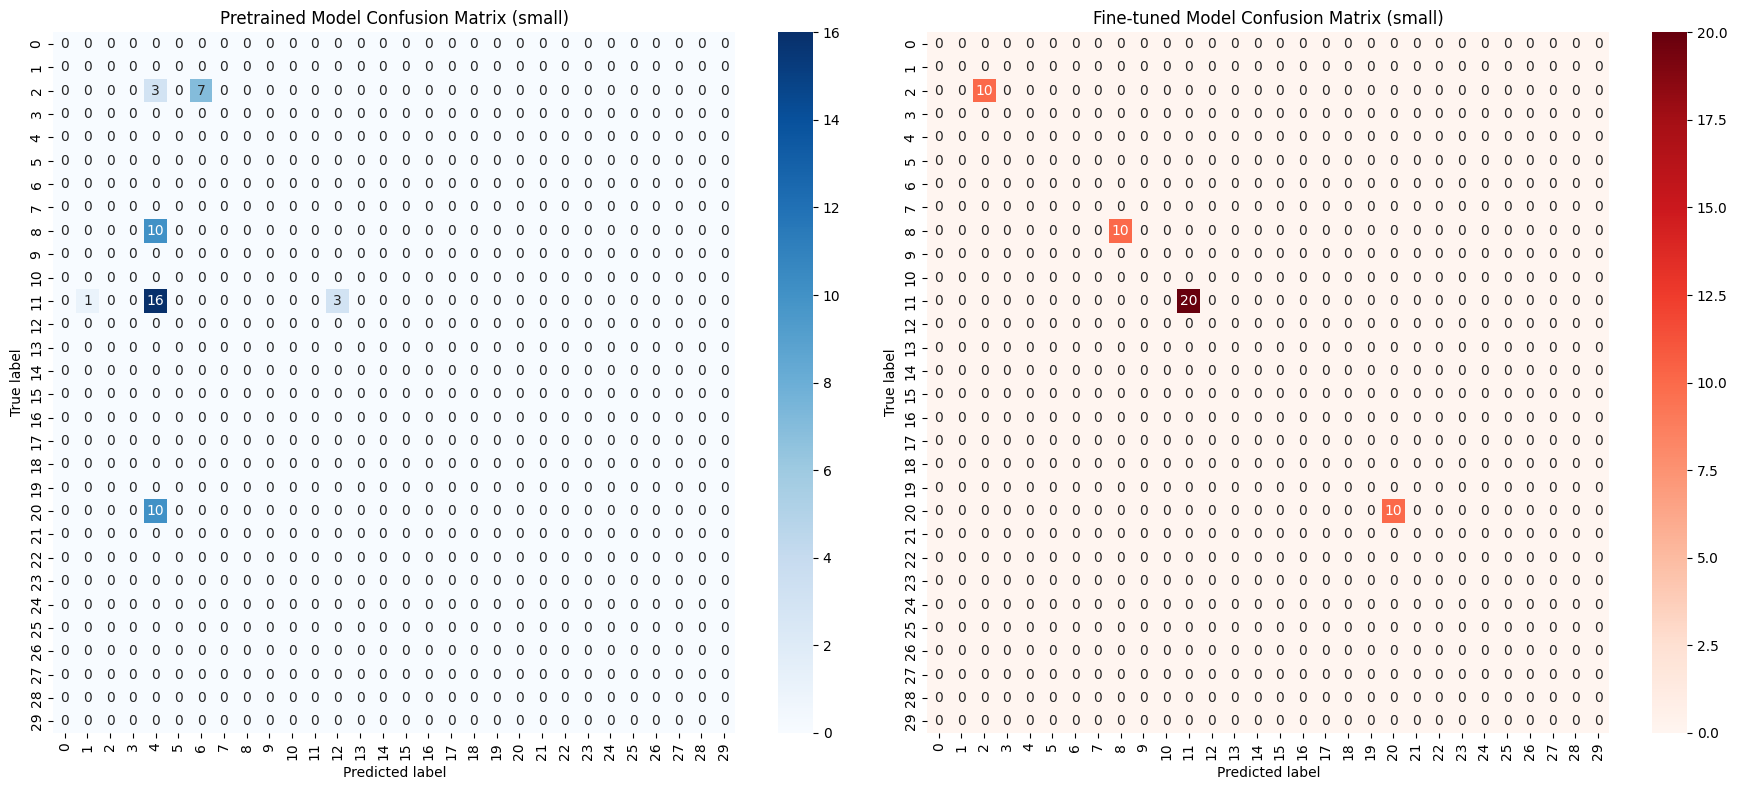

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


<Figure size 640x480 with 0 Axes>

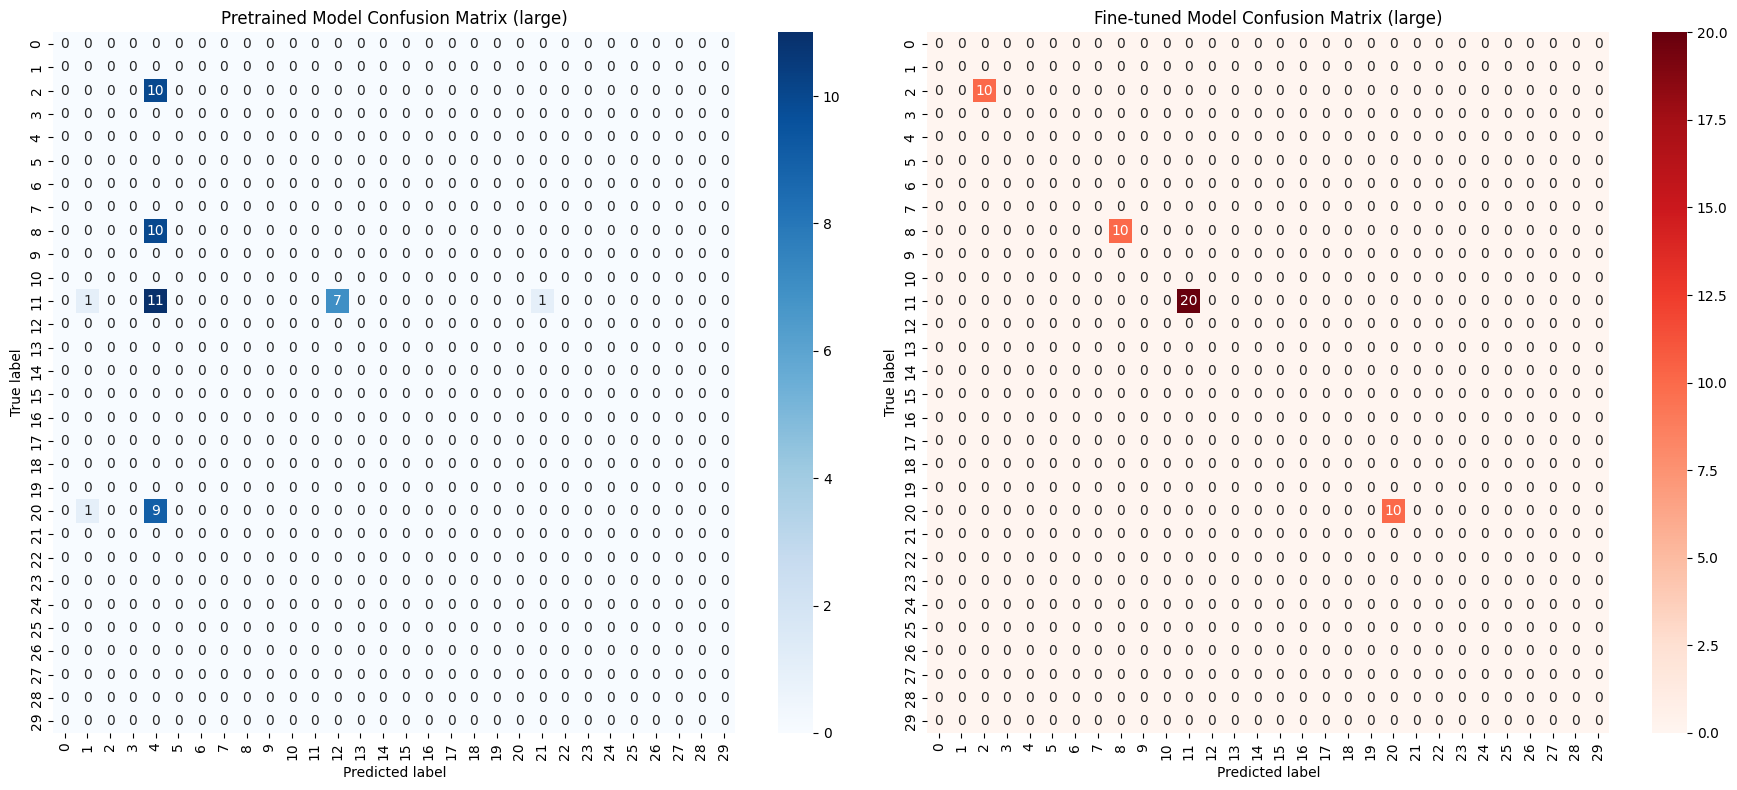

<Figure size 640x480 with 0 Axes>

In [31]:
# TODO: Compare to the pre-trained model
pretrained_model = load_model('example_model.hdf5', compile=False)
pretrained_model.compile(optimizer=Adam(learning_rate=9.999999747378752e-05), loss='categorical_crossentropy')
# pretrained_model.summary()
from tensorflow.keras.utils import to_categorical

# One-hot encode the target labels
y_small_one_hot = to_categorical(y_small, num_classes=30)
y_large_one_hot = to_categorical(y_large, num_classes=30)

# Evaluate the pretrained model on the small-room data and large-room data
pretrain_acc_small = pretrained_model.evaluate(X_small, y_small_one_hot, verbose=0)
pretrain_acc_large = pretrained_model.evaluate(X_large, y_large_one_hot, verbose=0)
print(f"Pretrained model accuracy on small-room data: {pretrain_acc_small:.2f}%")
print(f"Pretrained model accuracy on large-room data: {pretrain_acc_large:.2f}%")

best_small_train_model = load_model(f"{MODEL_PATH}/best_small_train_model.h5", compile=False)
best_small_train_model.compile(optimizer=Adam(learning_rate=9.999999747378752e-05), loss='categorical_crossentropy')
best_large_train_model = load_model(f"{MODEL_PATH}/best_large_train_model.h5", compile=False)
best_large_train_model.compile(optimizer=Adam(learning_rate=9.999999747378752e-05), loss='categorical_crossentropy')

# Evaluate the fine-tuned model on the small-room data and large-room data
fine_tuned_acc_small = best_small_train_model.evaluate(X_small, y_small_one_hot, verbose=0)
fine_tuned_acc_large = best_large_train_model.evaluate(X_large, y_large_one_hot, verbose=0)
print(
    f"Fine tuned model accuracy on small-room data: {fine_tuned_acc_small:.2f}%")
print(
    f"Fine tuned model accuracy on large-room data: {fine_tuned_acc_large:.2f}%")

# Create a confusion matrix comparing the pretrained model and the fine-tuned model
def compare_models(y_true, y_pred_pretrained, y_pred_fine_tuned, labels, env):
    cm_pretrained = confusion_matrix(y_true, y_pred_pretrained, labels=labels)
    cm_fine_tuned = confusion_matrix(y_true, y_pred_fine_tuned, labels=labels)

    cm_df_pretrained = pd.DataFrame(cm_pretrained, index=labels, columns=labels)
    cm_df_fine_tuned = pd.DataFrame(cm_fine_tuned, index=labels, columns=labels)

    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    sns.heatmap(cm_df_pretrained, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title(f'Pretrained Model Confusion Matrix ({env})')
    axes[0].set_ylabel('True label')
    axes[0].set_xlabel('Predicted label')

    sns.heatmap(cm_df_fine_tuned, annot=True, fmt='d', cmap='Reds', ax=axes[1])
    axes[1].set_title(f'Fine-tuned Model Confusion Matrix ({env})')
    axes[1].set_ylabel('True label')
    axes[1].set_xlabel('Predicted label')

    plt.tight_layout()
    plt.show()
    plt.savefig(f"pretrain_vs_finetune_{env}.png")

compare_models(
    y_true=y_small,
    y_pred_pretrained=pretrained_model.predict(X_small).argmax(axis=1),
    y_pred_fine_tuned=best_small_train_model.predict(X_small).argmax(axis=1),
    labels=list(UBICOUSTICS_LABELS.values()),
    env='small'
)
compare_models(
    y_true=y_large,
    y_pred_pretrained=pretrained_model.predict(X_large).argmax(axis=1),
    y_pred_fine_tuned=best_large_train_model.predict(X_large).argmax(axis=1),
    labels=list(UBICOUSTICS_LABELS.values()) ,
    env='large'
)

**Discussion:** Summarize the outcome of your hyperparameter search in your report.

*   List the test accuracies for the different combinations you tried (you can present this in a brief table or bullet list). Indicate which combination had the highest accuracy for small->large and which had the highest for large->small.
*   Identify your chosen "optimal" hyperparameters (learning rate = ?, epochs = ?). If the optimal differs for the two directions, you can mention both or choose one that seems generally effective.
*   Note which layers you kept trainable during these experiments.

# A2.3: Evaluate on Holdout Dataset (10 points)

In this section, you will fine-tune the Ubicoustics model using **your own collected dataset across both environments** with the best hyperparameters you selected in A2.2. Then, evaluate the model on the **holdout dataset** provided on Dropbox (used in A1). **Do not train on the holdout dataset.**

## Instructions:
After evaluating, compare the model’s performance on the hold-out dataset from:
1. The model you fine-tuned in A2.2.
2. The pre-trained model you evaluated in A2.1.

If the performance of the A2.2 fine-tuned model is worse than A2.1, you may use A2.1 instead.

**Additional improvements:**
- Try different windowing strategies
- Apply noise subtraction or pre-processing
- Filter to use only windows with sound present

You may try different improvement strategies to account for the difficulty of the hold-out dataset (real-world examples), feel free to report what works and what doesn't.

In [35]:
# TODO: Load the holdout dataset (from A1.6 Dropbox link)
X_holdout = []  # Your holdout audio data prepared for model input
y_holdout = []  # Labels for holdout data (one-hot encoded or integers for classes)
audio_files_holdout = []  # List of file paths for your holdout audio recordings
true_labels_holdout = []  # List of true labels (e.g., 'cough', 'laugh', etc.) for each recording
file_list_holdout = os.listdir("holdout_dataset")
# holdout_dataset is a directory containing directories for each activity with .wav files in them
for activity in ACTIVITIES:
    activity_dir = os.path.join("holdout_dataset", activity)
    if not os.path.isdir(activity_dir):
        print(f"Skipping {activity_dir} as it is not a directory.")
        continue
    for file in os.listdir(activity_dir):
        if file.endswith('.wav'):
            path = os.path.join(activity_dir, file)
            audio_files_holdout.append(path)
            true_labels_holdout.append(activity)
            # Assuming all holdout data is from the same environment
assert len(audio_files_holdout) == len(true_labels_holdout), "Mismatch in number of holdout audio files and true labels"
print(f"Found {len(audio_files_holdout)} holdout audio files.")

# Build X_holdout and y_holdout
zipped_data_holdout = list(zip(audio_files_holdout, true_labels_holdout))
for audio_file, true_label in tqdm(zipped_data_holdout):
    # Load the audio file
    audio, sr = librosa.load(audio_file, sr=SAMPLE_RATE)
    # Convert to VGGish input format
    examples = waveform_to_examples(audio, sr)
    # examples.reshape(len(examples), 96, 64, 1)  # Reshape to match model input
    examples = examples[..., np.newaxis]  # (96, 64, 1) for VGGish
    features = np.mean(examples, axis=0)  # Mean pooling to get a single feature vector
    ubi_label = UBICOUSTICS_MAPPING.get(true_label, "unknown")  # Map to Ubicoustics labels
    label = UBICOUSTICS_LABELS.get(ubi_label, -1)  # Get the integer label
    X_holdout.append(features)
    y_holdout.append(label)
X_holdout = np.array(X_holdout)
y_holdout = np.array(y_holdout)

# TODO: Train on all your collected data using best hyperparameters from A2.2
lr = 1e-4
num_epochs = 30
frozen_layers = -1
model, history = grid_search_fine_tuning(
    X_train=np.concatenate((X_small, X_large)),
    y_train=np.concatenate((y_small, y_large)),
    X_test=X_holdout,
    y_test=y_holdout,
    lr=lr,
    num_epochs=num_epochs,
    frozen_layers=frozen_layers
)

# TODO: additional improvements (different windowing, noise reduction, preprocessing)

# Evaluate on the holdout dataset


Found 25 holdout audio files.


  0%|          | 0/25 [00:00<?, ?it/s]

All layers are trainable
Total parameters: 72145054
Trainable parameters: 72145054
Non-trainable parameters: 0
Test accuracy: 0.6000000238418579
Test loss: 1.937239408493042


**Discussion:** In your report:

*   What was the test accuracy on the holdout set?
*   Did the model fine-tuned on your collected data (A2.2) outperform the pre-trained model (A2.1)? If not, which model are you choosing and why?
*   How does this final result compare to your best model from Assignment 1?
*   Which fine-tuning strategy yielded better performance on your data? ("Last layer only" vs "All layers") How big was the difference? What might explain this difference? (If the difference is small, the pre-trained feature extraction might already be well-suited to the task; if the "all layers" is better, it suggests the model could further adapt its internal representations to your data; if "all layers" is worse, perhaps it overfit the combined data or disrupted some of the pre-trained features.)

# Submission

Please ensure you have completed all sections above:

1.   All code placeholders (TODOs) should be filled with working code implementing the required functionality.
2.   All discussion prompts should be answered in your report with your observations and explanations.
3.   Run all cells in order before submission to ensure that the notebook executes without errors from start to finish and that all outputs (accuracies, plots, etc.) are visible.
4.   Save your notebook with the outputs (e.g., in Google Colab go to File > Save a copy in Drive or File > Download .ipynb after running everything).